In [51]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve


In [52]:
ROOT = Path('/home/kylehiroyasu/programming/masters_thesis/stochastic-YOLO')

In [53]:
files = [f for f in os.listdir(ROOT) if 'csv' in f]
files.sort()
files

['None.csv',
 'all_test_results.csv',
 'ccpd.csv',
 'ccpd_blur.csv',
 'ccpd_blur_dropout.csv',
 'ccpd_blur_ensemble.csv',
 'ccpd_challenge.csv',
 'ccpd_challenge_dropout.csv',
 'ccpd_challenge_ensemble.csv',
 'ccpd_db.csv',
 'ccpd_db_dropout.csv',
 'ccpd_db_ensemble.csv',
 'ccpd_dropout.csv',
 'ccpd_ensemble.csv',
 'ccpd_fn.csv',
 'ccpd_fn_dropout.csv',
 'ccpd_fn_ensemble.csv',
 'ccpd_rotate.csv',
 'ccpd_rotate_dropout.csv',
 'ccpd_rotate_ensemble.csv',
 'ccpd_tilt.csv',
 'ccpd_tilt_dropout.csv',
 'ccpd_tilt_ensemble.csv']

In [66]:
files = [
    'ccpd_blur.csv',
    'ccpd_blur_dropout.csv',
    'ccpd_blur_ensemble.csv',
    'ccpd_challenge.csv',
    'ccpd_challenge_dropout.csv',
    'ccpd_challenge_ensemble.csv',
    'ccpd_db.csv',
    'ccpd_db_dropout.csv',
    'ccpd_db_ensemble.csv',
    'ccpd_fn.csv',
    'ccpd_fn_dropout.csv',
    'ccpd_fn_ensemble.csv',
    'ccpd_rotate.csv',
    'ccpd_rotate_dropout.csv',
    'ccpd_rotate_ensemble.csv',
    'ccpd_tilt.csv',
    'ccpd_tilt_dropout.csv',
    'ccpd_tilt_ensemble.csv',
    'ccpd.csv',
    'ccpd_dropout.csv',
    'ccpd_ensemble.csv'
]

In [67]:
groups = ['blur', 'challenge', 'db', 'fn', 'rotate', 'tilt', 'val']

In [68]:
def load_data(path: str):
    all_predictions = []
    with open(path, mode='r') as f:
        for line in f.readlines():
            prediction = json.loads(line)
            for correct, confidence, bbv, entropy in zip(prediction['correct'], prediction['confidence'], prediction['bounding_box_variance'], prediction['entropy']):
                data = {
                    'image_name': prediction['image_name'],
                    'correct': correct[0],
                    'confidence': confidence,
                    'bounding_box_variance':bbv,
                    'entropy': entropy
                }
                all_predictions.append(data)
    return pd.DataFrame(all_predictions)

In [69]:
def plot_calibration_curve(data_dict: dict, dataset_name: str,  fig_index):


    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for name, df in data_dict.items():
        y_test = df.correct
        prob_pos = df.confidence
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        #print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        #print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        #print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plots {dataset_name} (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [70]:
datasets = []
for i in range(0, len(files), 3):
    data = load_data(ROOT/files[i])
    dropout_data = load_data(ROOT/files[i+1])
    ensemble_data = load_data(ROOT/files[i+2])
    datasets.append({
        'Normal': data,
        'MC-Dropout (10 samples)': dropout_data,
        'Ensemble': ensemble_data
    })

Normal:
	Brier: 0.246
MC-Dropout (10 samples):
	Brier: 0.264
Ensemble:
	Brier: 0.246
Normal:
	Brier: 0.254
MC-Dropout (10 samples):
	Brier: 0.272
Ensemble:
	Brier: 0.254
Normal:
	Brier: 0.234
MC-Dropout (10 samples):
	Brier: 0.260
Ensemble:
	Brier: 0.234
Normal:
	Brier: 0.195
MC-Dropout (10 samples):
	Brier: 0.198
Ensemble:
	Brier: 0.195
Normal:
	Brier: 0.281
MC-Dropout (10 samples):
	Brier: 0.314
Ensemble:
	Brier: 0.281
Normal:
	Brier: 0.243
MC-Dropout (10 samples):
	Brier: 0.264
Ensemble:
	Brier: 0.243
Normal:
	Brier: 0.330
MC-Dropout (10 samples):
	Brier: 0.348
Ensemble:
	Brier: 0.330


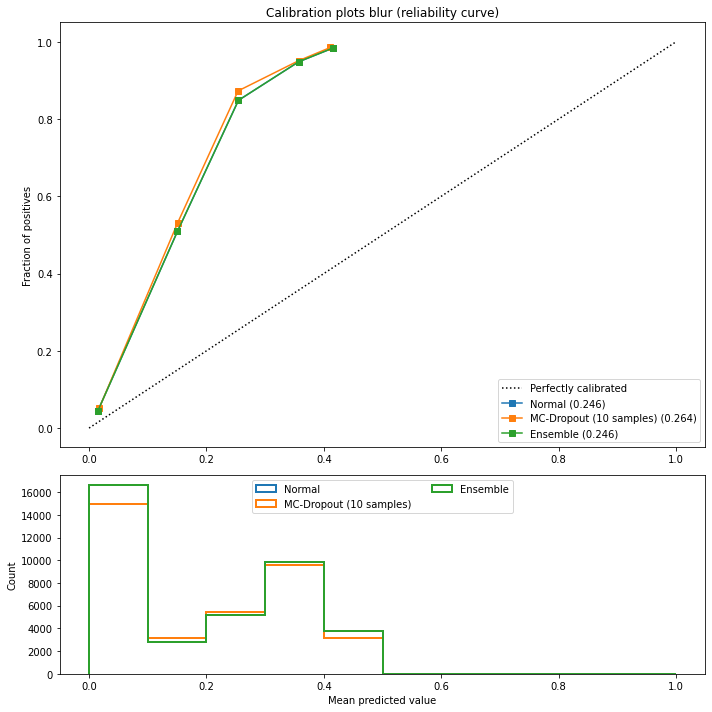

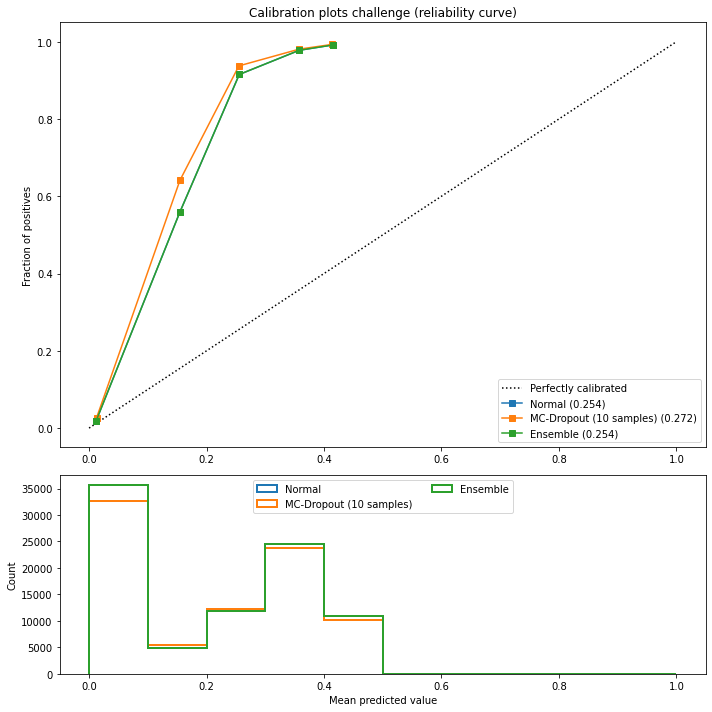

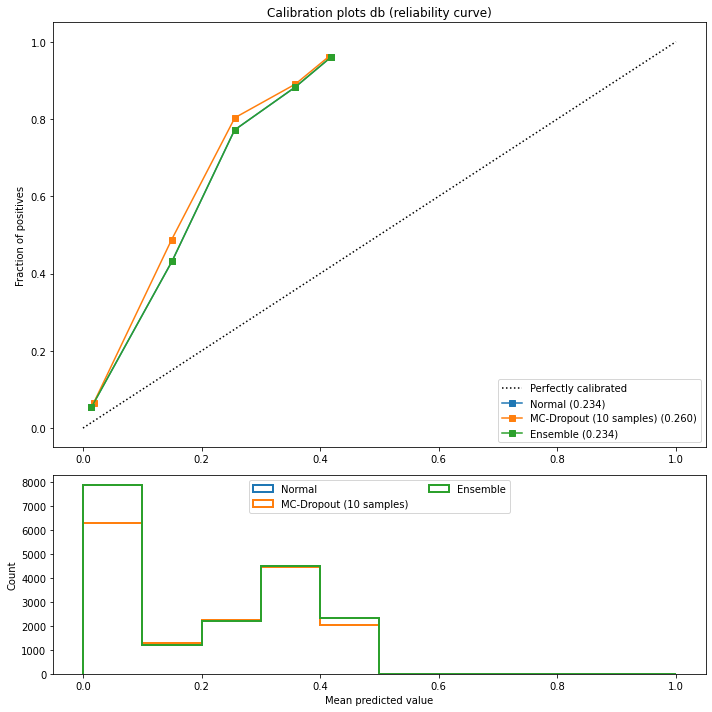

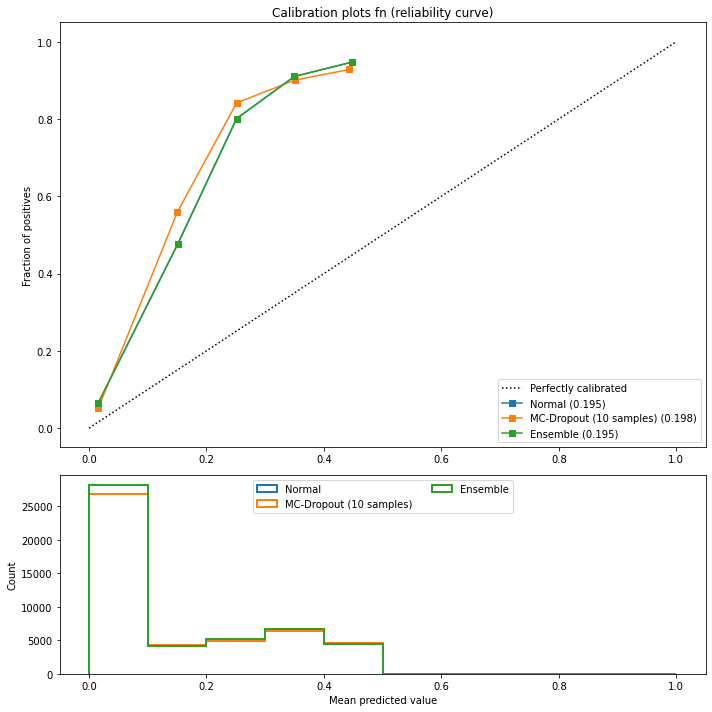

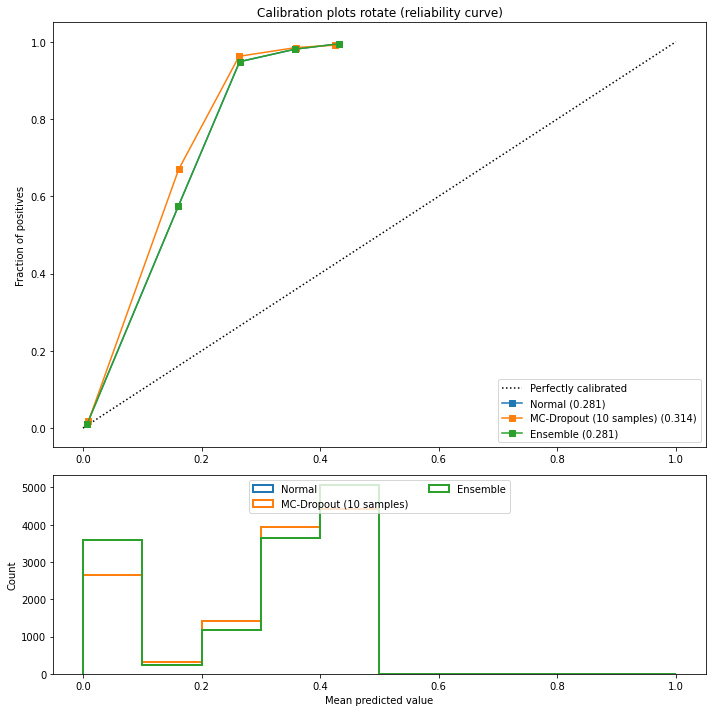

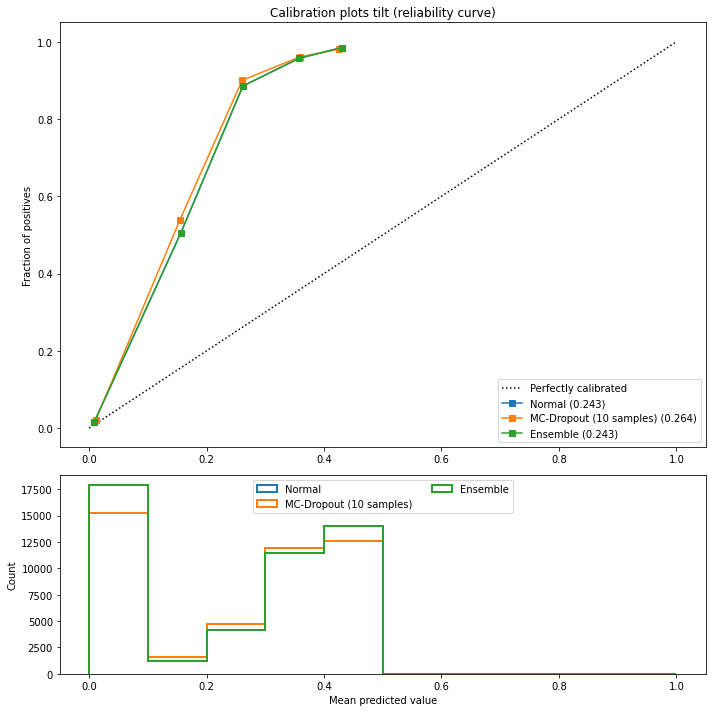

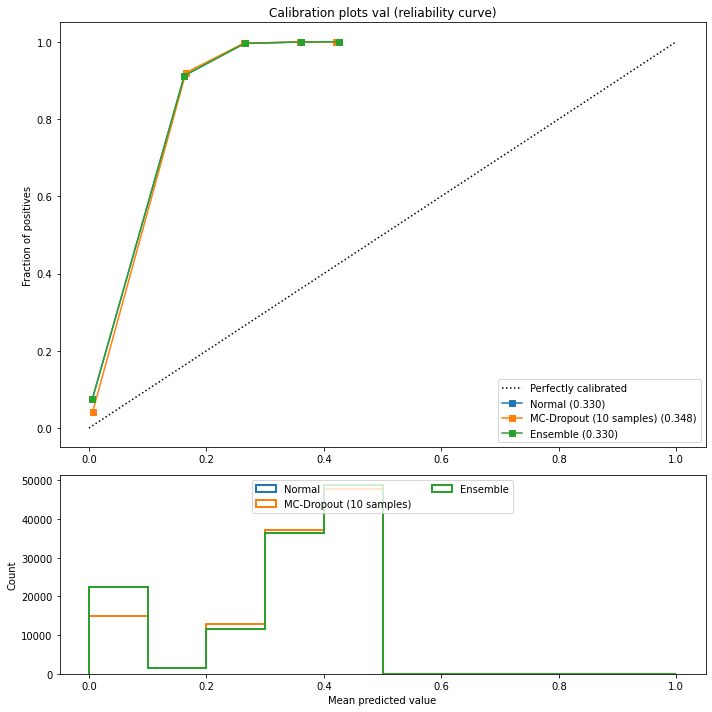

In [71]:
for i, (name, data_dict) in enumerate(zip(groups, datasets)):
    plot_calibration_curve(data_dict=data_dict, dataset_name=name, fig_index=i)

In [72]:
all_results = []
for group, data in zip(groups, datasets):
    for k, df in data.items():
        df['model'] = k
        df['dataset'] = group
        all_results.append(df)
dataset_results = pd.concat(all_results)


In [73]:
mean_results = dataset_results.groupby(by=['dataset','model']).mean()
mean_results

correct  confidence  \
dataset   model                                           
blur      Ensemble                 0.512285    0.184678   
          MC-Dropout (10 samples)  0.536570    0.188790   
          Normal                   0.512285    0.184678   
challenge Ensemble                 0.558753    0.199722   
          MC-Dropout (10 samples)  0.584618    0.202922   
          Normal                   0.558753    0.199722   
db        Ensemble                 0.489361    0.190224   
          MC-Dropout (10 samples)  0.537124    0.203492   
          Normal                   0.489361    0.190224   
fn        Ensemble                 0.373942    0.137259   
          MC-Dropout (10 samples)  0.382245    0.140000   
          Normal                   0.373942    0.137259   
rotate    Ensemble                 0.722162    0.282012   
          MC-Dropout (10 samples)  0.776890    0.293978   
          Normal                   0.722162    0.282012   
tilt      Ensemble                 0.601767    0.237184   
          MC-Dropout (10 samples)  0.634604    0.244824   
          Normal                   0.601767    0.237184   
val       Ensemble                 0.826093    0.309013   
          MC-Dropout (10 samples)  0.872669    0.325699   
          Normal                   0.826093    0.309013   

                                   bounding_box_variance   entropy  
dataset   model                                                     
blur      Ensemble                              0.000000  0.369556  
          MC-Dropout (10 samples)               5.282010  0.383276  
          Normal                                0.000000  0.369556  
challenge Ensemble                              0.000000  0.387876  
          MC-Dropout (10 samples)               3.502672  0.397165  
          Normal                                0.000000  0.387876  
db        Ensemble                              0.000000  0.373033  
          MC-Dropout (10 samples)               6.544496  0.402494  
          Normal                                0.000000  0.373033  
fn        Ensemble                              0.000000  0.285556  
          MC-Dropout (10 samples)              13.314266  0.291659  
          Normal                                0.000000  0.285556  
rotate    Ensemble                              0.000000  0.491119  
          MC-Dropout (10 samples)               8.847689  0.522157  
          Normal                                0.000000  0.491119  
tilt      Ensemble                              0.000000  0.423943  
          MC-Dropout (10 samples)              10.926200  0.444906  
          Normal                                0.000000  0.423943  
val       Ensemble                              0.000000  0.538103  
          MC-Dropout (10 samples)               6.160924  0.570799  
          Normal                                0.000000  0.538103

<AxesSubplot:ylabel='dataset,model'>

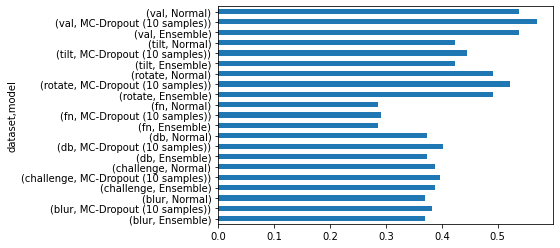

In [74]:
mean_results.entropy.plot.barh()